# Matthieu Cazier

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

#### Librairies

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import missingno as msno


from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm

import shap


pd.set_option('display.max_columns',335)
pd.set_option('display.max_rows',335)

In [3]:
df = pd.read_csv('df.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(['Prev_FLAG_LAST_APPL_PER_CONTRACT'],axis=1)

#### Remplacer les valeurs manquantes

In [4]:
for col in df:
    median = df[col].median()
    df[col].fillna(median, inplace=True)

#### Découverte du dataset

In [5]:
#Nombre de valeurs manquantes
#def num_missing(df):
#    return sum(df.isnull())
# On applique cette fonction pour chaque colonne:
#print("Valeursmanquantes par colonne:")
#print(df.apply(num_missing, axis=0))

In [6]:
regulier = df.loc[df['TARGET']==0].shape

In [7]:
defaut_paiement = df.loc[df['TARGET']==1].shape

In [8]:
df.shape

(307511, 334)

<BarContainer object of 2 artists>

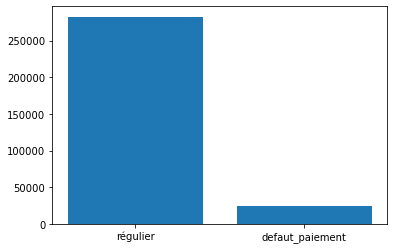

In [9]:
plt.bar(['régulier','defaut_paiement'],[regulier[0],defaut_paiement[0]])

#### Découpe du dataset et nombre de colonnes choisies dans avec SelectKBest

In [10]:
X = df.drop(['TARGET'],axis=1) 
y = df['TARGET']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=0)
print('train set: ', X_train.shape)
print('test set: ', X_test.shape)

train set:  (1160, 333)
test set:  (291, 333)


In [43]:
### normaliser les données 
#scaler = MinMaxScaler() 
#X_train_nor = scaler.fit_transform(X_train) 
#X_train.loc[:,:] = X_train_nor

In [44]:
#select = SelectKBest(chi2, k = 70)
#X_new = select.fit_transform(X_train, y_train) 
#names = X_train.columns.values[select.get_support()] 
#scores = select.scores_[select.get_support()] 
#names_scores = list(zip(names, scores)) 
#ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores']) 

####Sort the dataframe for better visualization 
#ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True]) 
#print(ns_df_sorted) 

                                           Feat_names   F_Scores
55              Prev_NAME_GOODS_CATEGORY_Direct Sales  11.366667
30                          Bureau_CREDIT_DAY_OVERDUE  10.542351
49               Prev_NAME_TYPE_SUITE_Group of people   6.092173
61             Prev_NAME_SELLER_INDUSTRY_MLM partners   2.977530
68             Prev_POS_NAME_CONTRACT_STATUS_Approved   2.604788
15                        REGION_RATING_CLIENT_W_CITY   2.365591
0                                  NAME_CONTRACT_TYPE   2.269978
14                               REGION_RATING_CLIENT   2.262026
8                                       DAYS_EMPLOYED   2.158392
20                                    FLAG_DOCUMENT_3   2.114978
18                                       EXT_SOURCE_2   1.854624
66                                Prev_CCB_SK_DPD_DEF   1.832356
33                            Bureau_Balance_STATUS_1   1.709923
65                Prev_CCB_CNT_DRAWINGS_OTHER_CURRENT   1.668815
31                       

#### Entrainer avec différents modèles puis les évaluer

In [58]:
forest = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), RandomForestClassifier(random_state=0,class_weight="balanced")) 
knn = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), KNeighborsClassifier())
logistic = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), LogisticRegression(random_state=0,class_weight="balanced"))
lgbm = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), lightgbm.LGBMClassifier(random_state=0,class_weight="balanced"))

##### creer ma propre métrique propre à la problématique métier

In [2]:
def custom_metric (y_true, y_train):
    #### valeur la plus importante
    b = ((y_true != y_train) & (y_true == 1)).sum()  #  y_true = 1 defaut de paiement /// y_train 0 régulier
    a = 5
    c = b*a 
    #### compter le maximum d'erreurs avec la valeur la plus importante
    z = (y_true == 1).sum()
    y = 5*z
    #### valeur un peu moins importante
    d = ((y_true != y_train) & (y_true == 0)).sum()
    e = 1
    f = d*e
    #### compter le maximum d'erreurs avec la valeur un peu moins importante
    x = (y_true == 0).sum()
    v = 1*x
    #### maximum si tout est faux
    t = v + y
    #### erreur importante + erreur moins importante / le maximum si tout est faux 
    g = (c+f)/t
    
    
    return -g     # par rapport a greater is better

In [60]:
custom_score = make_scorer (custom_metric, greater_is_better =True)

In [61]:
liste = [forest,knn,logistic,lgbm]
fit_time = {}
score_time = {}
test_ma_metric = {}
train_ma_metric = {}
test_recall = {}
train_recall = {}
test_f1 = {}
train_f1 = {}

listes = ['forest','knn','logistic','lgbm']

for elt,elts in zip(liste,listes):
    score = cross_validate(elt,X_train,y_train,cv=3,
                           scoring={'ma_metric':custom_score,
                                    'recall':make_scorer(recall_score),
                                    'f1':make_scorer(f1_score)},
                           return_train_score=True)
   
    fit_time[f"{elts}"] = round(score['fit_time'].mean(),3)
    score_time[f"{elts}"] = round(score['score_time'].mean(),3)
    test_ma_metric[f"{elts}"] = round(score['test_ma_metric'].mean(),3)
    train_ma_metric[f"{elts}"] = round(score['train_ma_metric'].mean(),3)
    test_recall[f"{elts}"] = round(score['test_recall'].mean(),3)
    train_recall[f"{elts}"] = round(score['train_recall'].mean(),3)
    test_f1[f"{elts}"] = round(score['test_f1'].mean(),3)
    train_f1[f"{elts}"] = round(score['train_f1'].mean(),3)

In [62]:
test_ma_metric

{'forest': -0.306, 'knn': -0.307, 'logistic': -0.312, 'lgbm': -0.311}

###### Visualisation

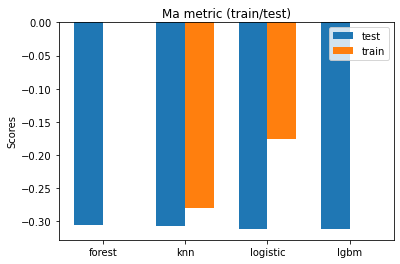

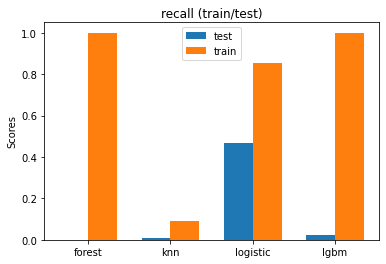

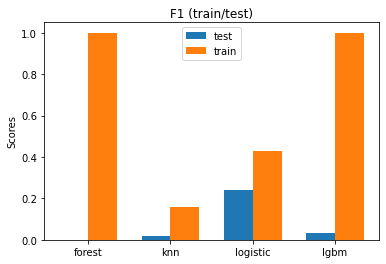

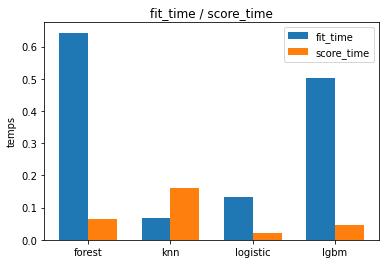

In [63]:
labels = test_ma_metric.keys()
width = 0.35  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots()
rects1 = plt.bar(np.arange(len(test_ma_metric.keys())) - width/2, test_ma_metric.values(), width, label='test')
rects2 = plt.bar(np.arange(len(train_ma_metric.keys())) + width/2, train_ma_metric.values(), width, label='train')

ax.set_ylabel('Scores')
ax.set_title('Ma metric (train/test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig, ax = plt.subplots()
rects1 = plt.bar(np.arange(len(test_recall.keys())) - width/2, test_recall.values(), width, label='test')
rects2 = plt.bar(np.arange(len(train_recall.keys())) + width/2, train_recall.values(), width, label='train')

ax.set_ylabel('Scores')
ax.set_title('recall (train/test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig, ax = plt.subplots()
rects1 = plt.bar(np.arange(len(test_f1.keys())) - width/2, test_f1.values(), width, label='test')
rects2 = plt.bar(np.arange(len(train_f1.keys())) + width/2, train_f1.values(), width, label='train')

ax.set_ylabel('Scores')
ax.set_title('F1 (train/test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



fig, ax = plt.subplots()
rects1 = plt.bar(np.arange(len(fit_time.keys())) - width/2, fit_time.values(), width, label='fit_time')
rects2 = plt.bar(np.arange(len(score_time.keys())) + width/2, score_time.values(), width, label='score_time')

ax.set_ylabel('temps')
ax.set_title('fit_time / score_time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Améliorer les 2 meilleurs modèles

##### LGBM

In [22]:
lgbm = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), lightgbm.LGBMClassifier(random_state=0,class_weight="balanced"))

In [26]:
lgbm

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('selectkbest',
                 SelectKBest(k=70,
                             score_func=<function chi2 at 0x00000264C3FF43A8>)),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', random_state=0))])

In [60]:
lgbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'selectkbest', 'lgbmclassifier', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'selectkbest__k', 'selectkbest__score_func', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight', 'lgbmclassifier__min_split_gain', 'lgbmclassifier__n_estimators', 'lgbmclassifier__n_jobs', 'lgbmclassifier__num_leaves', 'lgbmclassifier__objective', 'lgbmclassifier__random_state', 'lgbmclassifier__reg_alpha', 'lgbmclassifier__reg_lambda', 'lgbmclassifier__silent', 'lgbmclassifier__subsample', 'lgbmclassifier__subsample_for_bin', 'lgbmclassifier__subsample_freq'])

In [158]:
params = {'lgbmclassifier__num_leaves':np.arange(40,120),
          'lgbmclassifier__min_child_samples' :np.arange(40,120),
          'lgbmclassifier__boosting_type':['gbdt','goss','rf','dart'],  
         }
#31 valeur de base pour num_leave
#20 valeur de base pour min child samples
#gbdt
lgbm_random = RandomizedSearchCV(lgbm, params, cv=3,n_iter=40,scoring = custom_score)
lgbm_random.fit(X_train,y_train)

print("Tuned Decision Tree Parameters: {}".format(lgbm_random.best_params_))

Tuned Decision Tree Parameters: {'lgbmclassifier__num_leaves': 98, 'lgbmclassifier__min_child_samples': 48, 'lgbmclassifier__boosting_type': 'goss'}


In [160]:
lgbm_best = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), lightgbm.LGBMClassifier(random_state=0,
                                                                                            class_weight="balanced",
                                                                                            boosting_type='gbdt',
                                                                                            min_child_samples =48,
                                                                                            num_leaves = 98))

score_lgbm = cross_validate(lgbm_best,X_train,y_train,cv=3,
                        scoring={'ma_metric':custom_score,
                                 'recall':make_scorer(recall_score),
                                 'f1':make_scorer(f1_score)},
                       return_train_score=True)

fit_time_lgbm = round(score_lgbm['fit_time'].mean(),3)
score_time_lgbm = round(score_lgbm['score_time'].mean(),3)
test_ma_metric_lgbm = round(score_lgbm['test_ma_metric'].mean(),3)
train_ma_metric_lgbm = round(score_lgbm['train_ma_metric'].mean(),3)
test_recall_lgbm = round(score_lgbm['test_recall'].mean(),3)
train_recall_lgbm = round(score_lgbm['train_recall'].mean(),3)
test_f1_lgbm = round(score_lgbm['test_f1'].mean(),3)
train_f1_lgbm = round(score_lgbm['train_f1'].mean(),3)


In [161]:
#### récupérer les scores sans amélioration des params
result_lgbm_avant = [test_ma_metric['lgbm'],train_ma_metric['lgbm'],test_recall['lgbm'],train_recall['lgbm'],test_f1['lgbm'],train_f1['lgbm']]

In [162]:
#### mettre les résultats des meilleurs params dans une variable
result_lgbm = [test_ma_metric_lgbm,train_ma_metric_lgbm,test_recall_lgbm,train_recall_lgbm,test_f1_lgbm,train_f1_lgbm]

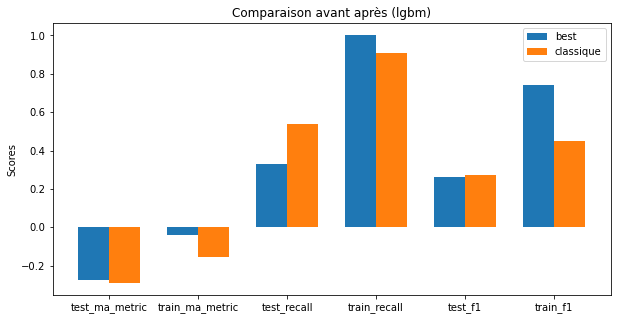

In [163]:
labels = ['test_ma_metric','train_ma_metric','test_recall','train_recall','test_f1','train_f1']
result_lgbm_best = result_lgbm
result_lgbm_before = result_lgbm_avant

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, result_lgbm_best, width, label='best')
rects2 = ax.bar(x + width/2, result_lgbm_before, width, label='classique')

ax.set_ylabel('Scores')
ax.set_title('Comparaison avant après (lgbm)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


##### Random forest

In [49]:
forest = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), RandomForestClassifier(random_state=0,class_weight="balanced"))

In [54]:
forest.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'selectkbest', 'randomforestclassifier', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'selectkbest__k', 'selectkbest__score_func', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [55]:
params = {'randomforestclassifier__min_samples_split': [1,2,3],
          'randomforestclassifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    
}
  
forest_random = RandomizedSearchCV(forest, params, cv=3,n_iter=140,scoring = custom_score)
forest_random.fit(X_train,y_train)



print("Tuned Decision Tree Parameters: {}".format(forest_random.best_params_))

Tuned Decision Tree Parameters: {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 10}


In [56]:
forest_best = make_pipeline(MinMaxScaler(),SelectKBest(chi2, k = 70), RandomForestClassifier(random_state=0,
                                                                                        class_weight="balanced",
                                                                                            min_samples_split =2 ,
                                                                                            max_depth=10,
                                                                                            min_samples_leaf=2 ))

score_forest = cross_validate(forest_best,X_train,y_train,cv=3,
                        scoring={'ma_metric':custom_score,
                                 'recall':make_scorer(recall_score),
                                 'f1':make_scorer(f1_score)},
                       return_train_score=True)

fit_time_forest = round(score_forest['fit_time'].mean(),3)
score_time_forest = round(score_forest['score_time'].mean(),3)
test_ma_metric_forest = round(score_forest['test_ma_metric'].mean(),3)
train_ma_metric_forest = round(score_forest['train_ma_metric'].mean(),3)
test_recall_forest = round(score_forest['test_recall'].mean(),3)
train_recall_forest = round(score_forest['train_recall'].mean(),3)
test_f1_forest = round(score_forest['test_f1'].mean(),3)
train_f1_forest = round(score_forest['train_f1'].mean(),3)

In [57]:
#### récupérer les scores sans amélioration des params
result_forest_avant = [test_ma_metric['forest'],train_ma_metric['forest'],test_recall['forest'],train_recall['forest'],test_f1['forest'],train_f1['forest']]

In [58]:
#### mettre les résultats des meilleurs params dans une variable
result_forest = [test_ma_metric_forest,train_ma_metric_forest,test_recall_forest,train_recall_forest,test_f1_forest,train_f1_forest]

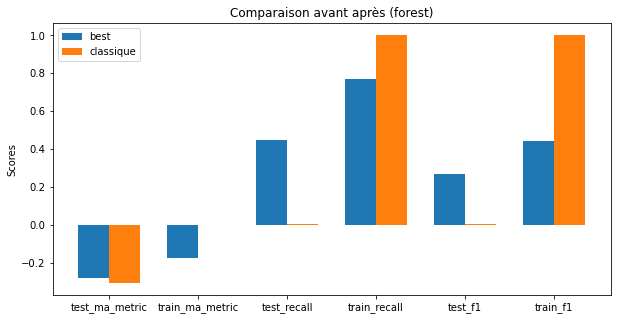

In [59]:
labels = ['test_ma_metric','train_ma_metric','test_recall','train_recall','test_f1','train_f1']
result_forest_best = result_forest
result_forest_before = result_forest_avant

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the rs

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, result_forest_best, width, label='best')
rects2 = ax.bar(x + width/2, result_forest_before, width, label='classique')

ax.set_ylabel('Scores')
ax.set_title('Comparaison avant après (forest)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### choix du meilleur modèle entre random forest et lgbm

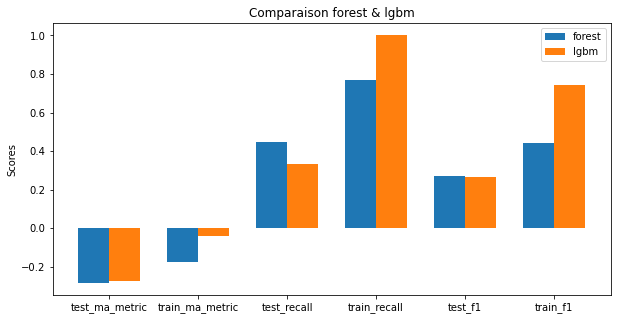

In [164]:
labels = ['test_ma_metric','train_ma_metric','test_recall','train_recall','test_f1','train_f1']
result_forest_best = result_forest
result_lgbm_best = result_lgbm

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, result_forest_best, width, label='forest')
rects2 = ax.bar(x + width/2, result_lgbm_best, width, label='lgbm')

ax.set_ylabel('Scores')
ax.set_title('Comparaison forest & lgbm')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Shap (lgbm)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=0)
print('train set: ', X_train.shape)
print('test set: ', X_test.shape)

train set:  (928, 333)
test set:  (232, 333)


#### Shap

In [37]:
### normaliser les données 
scaler = MinMaxScaler() 
X_train_nor = scaler.fit_transform(X_train) 
X_train.loc[:,:] = X_train_nor 

In [38]:
select = SelectKBest(chi2, k = 70)
X_new = select.fit_transform(X_train, y_train) 
names = X_train.columns.values[select.get_support()] 
scores = select.scores_[select.get_support()] 
names_scores = list(zip(names, scores)) 
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores']) 
#Sort the dataframe for better visualization 
#ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True]) 
#print(ns_df_sorted) 

In [39]:
#X_new = pd.DataFrame(X_new,columns=names) ### juste pour enregistrer sinon ne pas exécuter la cellule si je veut entrainer mon modèle

In [40]:
#X_new.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet7\X_train.csv')
#y_train.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet7\y_train.csv')

In [41]:
### les bests paramètres de random forest
lgbm_shap = lightgbm.LGBMClassifier(random_state=0,class_weight="balanced",boosting_type='gbdt',min_child_samples =48,num_leaves = 98)
lgbm_shap.fit(X_new,y_train)

LGBMClassifier(class_weight='balanced', min_child_samples=48, num_leaves=98,
               random_state=0)

In [42]:
# save lgbm
import joblib
joblib.dump(lgbm_shap, 'lgb.pkl')

['lgb.pkl']

In [43]:
X_new = pd.DataFrame(X_new,columns=names)

In [46]:
X_new.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet7\X_train.csv')
y_train.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet7\y_train.csv')

In [57]:
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgbm_shap,feature_dependence="independent")   ### rajouter les params : proba 
shap_values = explainer.shap_values(X_new)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_new.iloc[0,:],link="logit") ### 0 c'est pour la classe 0 / la classification te donnne 2 classes 

In [203]:
lgbm_shap.predict_proba(np.asarray(X_new.iloc[0,:])[None,:]) # récupérer le deuxième

array([[0.99765159, 0.00234841]])

In [48]:
prédiction = pd.DataFrame(lgbm_shap.predict_proba(X_new))

In [49]:
prédiction.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet7\prédiction.csv')

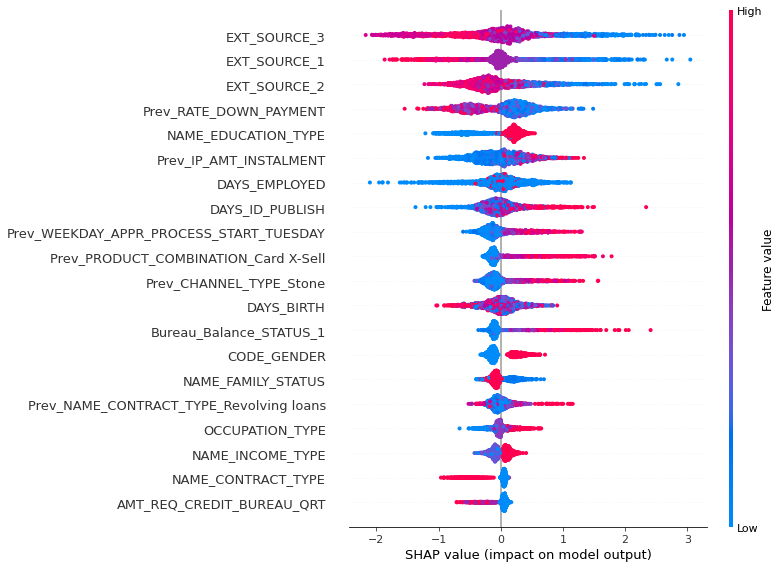

In [206]:
# Let us have a look on SHAP summary plot
samples = X_new

explainer = shap.TreeExplainer(lgbm_shap)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples,names) ## coté stramlit

ext_source : Score normalisé à partir d'une source de données externes. Une sorte de cote de crédit cumulative établie à l'aide de nombreuses sources de données.

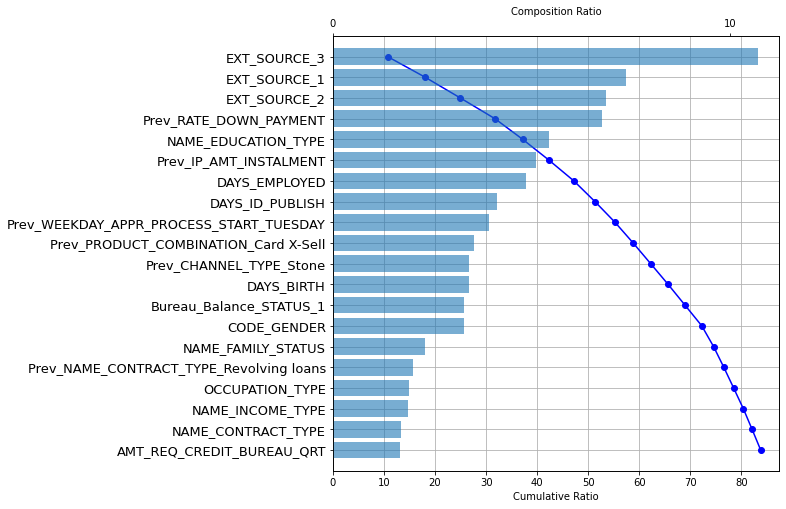

In [207]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = names
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)

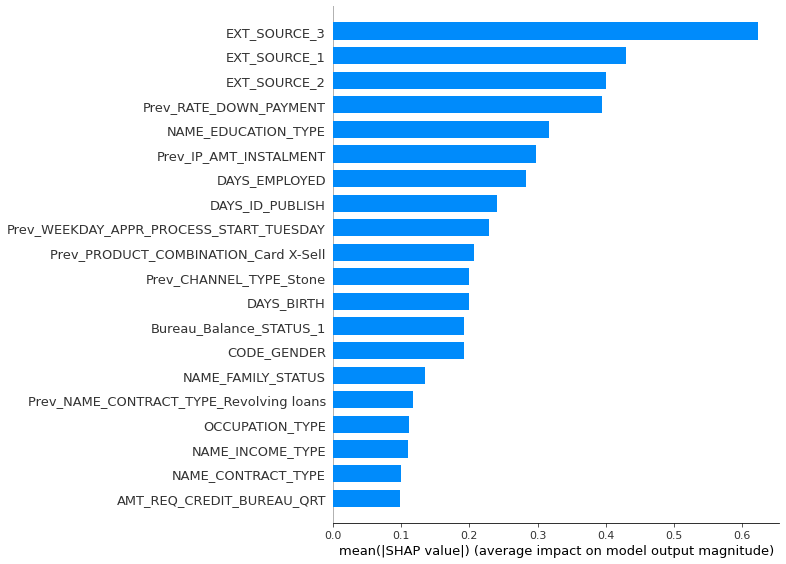

In [208]:
shap.summary_plot(shap_values[1], samples,names, plot_type="bar")